Clean model maker


In [1]:
#imports
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import tensorflow.keras.metrics # import Precision, Recall,Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import classification_report

# Set parameters

In [2]:
#for data splits
batch_size = 16 #None = 1 #16 #32
img_height = 224
img_width = 224
seed_train_validation = 69 # Must be same for train_ds and val_ds
shuffle_value = True
#validation_split = 0.2 irrelevant


In [3]:
new_way = True
label_mode = "int" 

def load_data_new_way():
    #path_to_dataset = os.path.join("..", "test_data", "3_test_from_bucket2")
    path_to_dataset = os.path.join("..","..","data")
    path_to_dataset_train = os.path.join(path_to_dataset, "train")
    path_to_dataset_test = os.path.join(path_to_dataset,  "test")
    path_to_dataset_val = os.path.join(path_to_dataset,   "val")
    
    X_train = image_dataset_from_directory(
        path_to_dataset_train,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_val = image_dataset_from_directory(
        path_to_dataset_val,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_test = image_dataset_from_directory(
        path_to_dataset_test,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=False
        )
    return X_train,X_val,X_test
X_train, X_val, X_test = load_data_new_way()

#print sample label

Found 17963 files belonging to 31 classes.
Found 3791 files belonging to 31 classes.
Found 3754 files belonging to 32 classes.


In [4]:
path_to_dataset = os.path.join("..", "data")#, "2_test_from_bucket")
#new_way = False
def load_data_old_way():
    path_to_dataset = os.path.join("..", "data")#, "2_test_from_bucket")
    val_split = 0.3
    
    X_train = image_dataset_from_directory(
        path_to_dataset,
        validation_split=val_split,
        subset="training",
        label_mode="int",
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    X_val_ds = image_dataset_from_directory(
        path_to_dataset,
        validation_split=val_split,
        subset="validation",
        label_mode="int",
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=shuffle_value
        )

    val_batches = tf.data.experimental.cardinality(X_val_ds)
    #print(val_batches//2)    # tf.Tensor(2131, shape=(), dtype=int64)

    X_val  = X_val_ds.take( val_batches // 2 ) #15%a
    X_test = X_val_ds.skip( val_batches // 2 ) #15%b
    
    return X_train,X_val,X_test

if new_way == False:
    X_train, X_val, X_test = load_data_old_way()

In [5]:
#(images, labels) = X_test
X_test


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
train_batches = tf.data.experimental.cardinality(X_train)
test_batches = tf.data.experimental.cardinality(X_test)
val_batches = tf.data.experimental.cardinality(X_val)

train_batches.numpy() , test_batches.numpy() ,val_batches.numpy()

(1123, 235, 237)

In [7]:
X_val


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Prep model

test label: [15 27 12  7 26  2  9  2  7 30 28 18 13 15 14 26]
first test label: 15


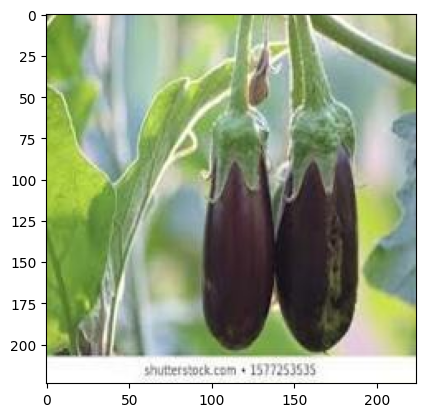

In [8]:
#get one image - I wish I knew a better way
count = 0
test_image, test_label = None, None

for image, label in X_train:#.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
    
#if you want to see an image
print("test label:", test_label)
print("first test label:", test_label[0])
plt.imshow(test_image[0]/255)


In [9]:
in_shape = test_image[0].shape
in_shape

num_classes = len(X_train.class_names)
print("num_classes: ", num_classes)
print("in_shape: "   , in_shape)

num_classes:  31
in_shape:  (224, 224, 3)


# Create model

In [10]:
#for model
epochs = 100
patience = 20
dropout_rate = 0.2

#learning rate!

In [11]:
#declare model
def instantiate_model():
    model = models.Sequential()

    #normalise the inputs
    model.add(layers.Rescaling(1./255))

    #first convolutional layer - big kernels, few filters
    model.add(layers.Conv2D(16, kernel_size=(5,5), padding="same", activation="relu", input_shape=in_shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #second conv layer
    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

#     model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
#     model.add(layers.MaxPool2D(pool_size=(2,2)))
    
#     model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
#     model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    #third conv layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Flatten
    model.add(layers.Flatten())

    #Dense layers - do we regularise the kernels?!
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) )
    #model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    #model.add(layers.Dropout(0.4) )
    #model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    #model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(32, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) )
    model.add(layers.Dense(16, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) ) 

    #Last layer, convert for appropriate model output
    model.add(layers.Dense(num_classes, activation="softmax"))
    #model.add(layers.Dense(num_classes, activation="softmax"))

    
    return model

model = instantiate_model()

In [15]:
#compile model
from tensorflow.keras import metrics as mets
def compile_model(model):
    loss = "sparse_categorical_crossentropy"
    # loss = "categorical_crossentropy"
    optimizer = "adam"
    
    metrics = ["accuracy"]
    #metrics = [Precision(), Recall(), Accuracy()]
    #metrics = [Precision()]
    
    #metrics = [mets.SparseCategoricalAccuracy(), "accuracy"] #??
    # metrics = [mets.CategoricalAccuracy()]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
model = compile_model(model)


In [17]:
def fit_model(model):
    #prep for early stopping
    es = EarlyStopping(patience=patience, restore_best_weights=True)

    #fit
    history = model.fit(
            X_train, 
            validation_data=X_val, 
            #epochs=epochs,
            epochs=5,
            callbacks=[es], 
            verbose=1
        )
    return history, model

history, model = fit_model(model)


#if below error, RESTART KERNEL(s)!:
# 2023-03-08 16:05:03.024852: E tensorflow/stream_executor/cuda/cuda_dnn.cc:373] 
# Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR

Epoch 1/5


ResourceExhaustedError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/backend.py", line 1922, in random_uniform
        seed=self.make_legacy_seed())

    ResourceExhaustedError: Exception encountered when calling layer "sequential" (type Sequential).
    
    OOM when allocating tensor with shape[50176,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
      • training=True
      • mask=None


## Saving model

In [ ]:
#model_name = "100_epochs_on_21_classes"
model_name = None
model_name = "sparse_accuracy_first_0907"

In [ ]:
def save_model(model, model_name):
    path_to_models = os.path.join("..","models")
    
    if not model_name:
        print("please give the model a name! #goodpractice")
        print("model NOT saved")
        return None
    
    model_path = os.path.join(path_to_models, model_name)
    model.save(model_path)
    
    return f"model saved in {path_to_models} as {model_name}"

In [ ]:
save_model(model, model_name)

## Getting y out

In [ ]:
#pull target out of tensorflow.dataset
#can do train test or val (seems that test is batches of 1?)
def get_y_from_X(X, batched=True):
    
    y_batched = []
    y = []
    
    for batch_image, batch_label in X:
        
        if batched:
            y_batched.append(batch_label.numpy())
        else:
            for image,label in zip(batch_image, batch_label):
                y.append(label.numpy())
     
    if batched:
        print("len y_batched", len(y_batched) )
        return y_batched
    else:
        print("len y", len(y))
        return y

In [ ]:
count=0

for thing, label in X_test.take(1):
    if count == 0:
        print(label)
    count += 1


In [ ]:
def get_y_test(X_test_in):
    y_test = get_y_from_X(X_test_in, batched=False)
    return y_test
    
def get_y_pred(X_test_in):
    #gets array with probabilities
    # if model_name != None:
    #     print(f"getting predictions from {model_name}")
    # else:
    #     print(f"getting predictions from unnamed (probably not saved) 'model'")
        
    y_pred_0 = model.predict(X_test, verbose=1)
    y_pred = []
    
    for pred in y_pred_0:
        y_pred.append(pred.argmax())
        
    return y_pred


In [ ]:
#get y_pred and y_true out of X_test, thanks to above funcs
y_pred = get_y_pred(X_test)
y_test = get_y_test(X_test)
y_pred;

In [ ]:
path_to_dataset = os.path.join("..", "test_data", "3_test_from_bucket2")
if new_way:
    path_to_dataset_train = os.path.join(path_to_dataset, "train")
    path_to_dataset_test = os.path.join(path_to_dataset,  "test")
    path_to_dataset_val = os.path.join(path_to_dataset,   "validation")

In [ ]:
def get_target_dict():
    if new_way:
        classes = os.listdir(path_to_dataset_train)
    else:
        classes = os.listdir(path_to_dataset)
    classes.sort()
    
    target_dict_out = {}
    for index, veg in enumerate(classes):
        target_dict_out[index] = veg
    
    return target_dict_out
target_dict = get_target_dict()
target_dict

In [ ]:
#can be useful to have them just as list
if new_way:
    classes_list = os.listdir(path_to_dataset_train)
else:
    classes_list = os.listdir(path_to_dataset)
classes_list.sort()
classes_list
classes_code = [i for i in range(len(classes_list))]
classes_code

In [ ]:
import pandas as pd
df = pd.DataFrame({"y_pred" : y_pred ,"y_test" : y_test})
df

## Looking at results

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes_list))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test,y_pred, labels=classes_code , normalize='true') #true as in truth
sns.heatmap(cm,xticklabels=classes_list, yticklabels=classes_list)

# EXPERIMENTATION

will move the good stuff above

#idea 
create random prediction func that we can run and inspect incorrect predictions?

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
out = classification_report(y_test, y_pred, output_dict=True)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MultiLabelConfusionMatrix
#out

In [ ]:
num_test = tf.data.experimental.cardinality(X_test)
num_test.numpy()

In [ ]:
y_pred = model.predict(X_test, verbose=1)

In [ ]:
num_test = tf.data.experimental.cardinality(X_test.take(1))
num_test.numpy()

In [ ]:
out = classification_report(y_true, y_pred, output_dict=True)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
cm = confusion_matrix(y_test,y_pred, labels=classes_code , normalize='true')

# cm_df = pd.DataFrame(cm,
#                      index = target_dict.values(), 
#                      columns = target_dict.values())

sns.heatmap(cm,xticklabels=classes_list, yticklabels=classes_list)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MultiLabelConfusionMatrix

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes_list))

In [ ]:
classes_list

In [ ]:
out

In [ ]:
#out

pred_comparison_limit = 10
count=0
for y_t, y_p in zip(y_true , y_pred):
    print(f"true: {y_t}  pred:{y_p}")
    count+=1
    
    if count > pred_comparison_limit:
        break

In [ ]:
#get labels from folders, must be done in 2 lines...
classes = os.listdir(path_to_dataset_train)
classes.sort()

In [ ]:
target_dict = {}
for index,classs in enumerate(classes):
    target_dict[index] = classs
    
print(target_dict.values())

In [ ]:
path_to_dataset

In [ ]:
#get one image - I wish I knew a better way
count = 0
test_image, test_label = None, None
for image, label in X_test.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
#if you want to see an image
print(test_label[0])
plt.imshow(test_image[0]/255)

In [ ]:
model.evaluate(X_test, return_dict=True)